In [1]:
import os

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf


In [3]:
IMG_SIZE = 160 # All images will be resized to 160x160

In [4]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# Data Preprocessing for melanoma

In [5]:
# input image dimensions
IMAGE_WIDTH=160
IMAGE_HEIGHT=160
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# red, green and blue channels
IMAGE_CHANNELS=3

In [6]:
dataframe = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
dataframe.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

In [7]:
dataframe=dataframe.drop(labels=["patient_id","sex","age_approx","anatom_site_general_challenge","diagnosis","benign_malignant"],axis=1)
dataframe["image_name"]=dataframe["image_name"].apply(lambda x:x+".jpg")
dataframe.shape

(33126, 2)

In [8]:
benign_df=dataframe[dataframe.target==0].copy()
malignant_df = dataframe[dataframe.target==1].copy()

In [9]:
benign_df.head(3)

,image_name,target
0,ISIC_2637011.jpg,0
1,ISIC_0015719.jpg,0
2,ISIC_0052212.jpg,0


In [10]:
malignant_df.head(3)

,image_name,target
91,ISIC_0149568.jpg,1
235,ISIC_0188432.jpg,1
314,ISIC_0207268.jpg,1


In [11]:
train_benign,val_benign = train_test_split(benign_df,test_size=0.2,random_state=0)
train_malignant, val_malignant = train_test_split(malignant_df,test_size=0.2,random_state=0)
print(train_benign.shape[0])
print(val_benign.shape[0])
print(train_malignant.shape[0])
print(val_malignant.shape[0])

26033
6509
467
117


In [12]:
train_malignant_oversampled = train_malignant.copy()
val_malignant_oversampled = val_malignant.copy()

while(True):
    if train_malignant_oversampled.shape[0] > train_benign.shape[0]:
        break
    train_malignant_oversampled = pd.concat([train_malignant_oversampled,train_malignant])

while(True):
    if val_malignant_oversampled.shape[0] > val_benign.shape[0]:
        break
    val_malignant_oversampled = pd.concat([val_malignant_oversampled,val_malignant])
    
print(train_benign.shape[0])
print(val_benign.shape[0])
print(train_malignant_oversampled.shape[0])
print(val_malignant_oversampled.shape[0])

26033
6509
26152
6552


In [13]:
train_df = pd.concat([train_benign,train_malignant_oversampled])
val_df = pd.concat([val_benign,val_malignant_oversampled])
print(train_df.shape)
print(val_df.shape)

(52185, 2)
(13061, 2)


In [14]:
train_df["target"] = train_df["target"].replace({0: 'benign', 1: 'malignant'}) 
val_df["target"] = val_df["target"].replace({0: 'benign', 1: 'malignant'}) 

In [15]:
train_df.head(5)

,image_name,target
19144,ISIC_5809628.jpg,benign
11364,ISIC_3500137.jpg,benign
8017,ISIC_2497305.jpg,benign
4969,ISIC_1592874.jpg,benign
3291,ISIC_1092935.jpg,benign


In [16]:
train_df = train_df.reset_index(drop=True)
validate_df = val_df.reset_index(drop=True)

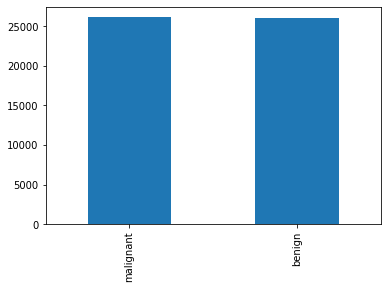

In [17]:
train_df['target'].value_counts().plot.bar()

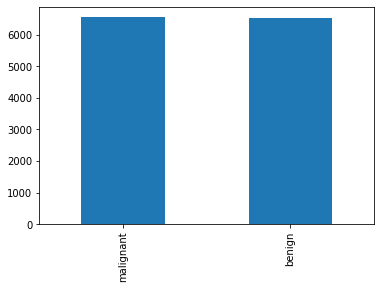

In [18]:
validate_df['target'].value_counts().plot.bar()

In [19]:
# get the total amount of data in train and validation set
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# set the minibatch size to 15
batch_size=32

In [20]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [21]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/siim-isic-melanoma-classification/jpeg2/train/", 
    x_col='image_name',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 52185 validated image filenames belonging to 2 classes.


In [22]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [23]:
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/siim-isic-melanoma-classification/jpeg2/train/",
    x_col='image_name',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 13061 validated image filenames belonging to 2 classes.


In [24]:
for image_batch, label_batch in train_generator:
   break

print(image_batch.shape)
print(label_batch)

(32, 160, 160, 3)
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [25]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
label_map

{0: 'benign', 1: 'malignant'}

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [26]:
IMG_SIZE = 160

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [27]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [28]:
base_model.trainable = True

In [29]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [30]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [31]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [32]:
base_learning_rate = 0.0001

In [33]:
len(model.trainable_variables)

158

### Train the model

After training for 10 epochs, you should see ~96% accuracy.


In [34]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            )

Using TensorFlow backend.


In [35]:
import os

class CustomSaver(tf.keras.callbacks.Callback):
    def __init__(self,directory):
        super().__init__()
        self.directory=directory
        if(os.path.isfile(self.directory+'/history.csv')!=True):
            history_df=pd.DataFrame(columns = ['loss','val_loss','accuracy','val_accuracy']) 
            history_df.to_csv(self.directory+'/history.csv',index=False)
        self.history_df = pd.read_csv(self.directory+'/history.csv')
        
    def on_epoch_end(self, epoch, logs={}):
        print("\nEpoch:",epoch)
        print("\nLoss:",logs["loss"],"Val_loss:",logs["val_loss"],"Accuracy:",logs["accuracy"],"Val_accuracy:",logs["val_accuracy"])
        self.model.save_weights(self.directory+"/model_"+str(self.history_df.shape[0])+".h5")
        print("\nSaved weights: "+self.directory+"/model_"+str(self.history_df.shape[0])+".h5")
        self.history_df=self.history_df.append({'loss':logs["loss"],
                   'val_loss':logs['val_loss'],
                   'accuracy':logs['accuracy'],
                   'val_accuracy':logs['val_accuracy']},ignore_index = True)
        self.history_df.to_csv(self.directory+'/history.csv',index=False)
        
    def latest_model(self):
        if(os.path.isfile(self.directory+'/history.csv') and pd.read_csv(self.directory+'/history.csv').shape[0]>0):
            iteration_to_be_loaded=pd.read_csv(self.directory+'/history.csv').shape[0]-1
            print(self.directory+"/model_"+str(iteration_to_be_loaded)+".h5"+" loaded!")
            return self.directory+"/model_"+str(iteration_to_be_loaded)+".h5"
            #model.load_weights("saved_model_3/model_"+str(iteration_to_be_loaded)+".h5")
        else:
            return self.directory+"/model.h5"
    
    def save_initial(self,model):
        model.save_weights(self.directory+"/model.h5")
         
saver = CustomSaver("saved_model_4")

callbacks = [saver,learning_rate_reduction]

In [36]:
initial_epochs = 10
validation_steps=20

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [37]:
base_model.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:]:
  layer.trainable =  True

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower learning rate.

In [39]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.RMSprop(lr=base_learning_rate), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [41]:
len(model.trainable_variables)

158

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [42]:
# saver.save_initial(model)

In [43]:
model.load_weights(saver.latest_model())

saved_model_4/model_4.h5 loaded!


In [44]:
history_fine = model.fit(train_generator,
                         epochs=10,
#                          epochs=total_epochs,
#                          initial_epoch =  history.epoch[-1],
                         validation_data=validation_generator,
                         callbacks = callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1631 steps, validate for 409 steps
Epoch 1/10
1630/1631 [============================>.] - ETA: 0s - loss: 0.0406 - accuracy: 0.9870
Epoch: 0

Loss: 0.04058796228683719 Val_loss: 2.67124478012542 Accuracy: 0.9869503 Val_accuracy: 0.6488018

Saved weights: saved_model_4/model_5.h5
1631/1631 [==============================] - 866s 531ms/step - loss: 0.0406 - accuracy: 0.9870 - val_loss: 2.6712 - val_accuracy: 0.6488
Epoch 2/10
 135/1631 [=>............................] - ETA: 12:09 - loss: 0.0342 - accuracy: 0.9876
Epoch: 1


KeyError: 'val_loss'

In [ ]:
assert False

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

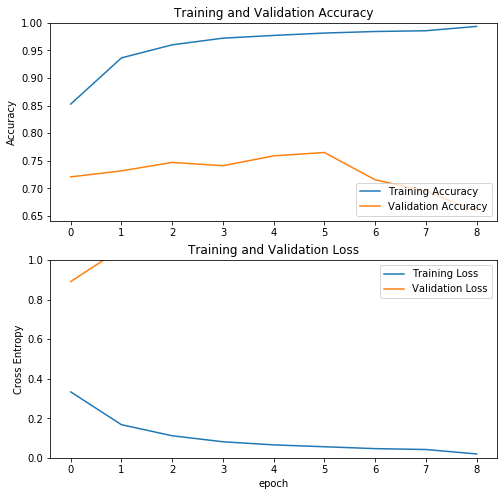

In [60]:
history_df = pd.read_csv("saved_model_4/history.csv")
acc = history_df['accuracy']
val_acc = history_df['val_accuracy']

loss = history_df['loss']
val_loss = history_df['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [61]:
pd.read_csv("saved_model_4/history.csv")

,loss,val_loss,accuracy,val_accuracy
0,0.333336,0.891557,0.852774,0.720695
1,0.167347,1.059014,0.936591,0.731567
2,0.111516,1.328034,0.960218,0.746880
3,0.081093,1.266609,0.972348,0.740908
4,0.065390,1.691863,0.977292,0.758824
5,0.055918,1.503251,0.981623,0.764949
6,0.046356,2.587538,0.984421,0.715412
7,0.042016,3.344979,0.985820,0.694893
8,0.019443,3.483393,0.993676,0.658143


In [72]:
iteration_to_be_loaded = 8
model.load_weights("saved_model_4/model_"+str(iteration_to_be_loaded)+".h5")

In [73]:
test_filenames = os.listdir("../input/siim-isic-melanoma-classification/jpeg2/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

10982

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_gen = ImageDataGenerator(rescale=1./255)

#remember to not shuffle the test set
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/siim-isic-melanoma-classification/jpeg2/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 10982 validated image filenames.


In [75]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [76]:
print(predict.shape)
predict

(10982, 2)


array([[9.9999535e-01, 4.6007626e-06],
       [1.0000000e+00, 9.2605475e-19],
       [1.0000000e+00, 2.7625298e-24],
       ...,
       [1.0000000e+00, 1.9002683e-10],
       [1.0000000e+00, 3.5193376e-10],
       [9.9999988e-01, 6.4283341e-08]], dtype=float32)

In [77]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
label_map

{0: 'benign', 1: 'malignant'}

In [78]:
predict[:,1]

array([4.6007626e-06, 9.2605475e-19, 2.7625298e-24, ..., 1.9002683e-10,
       3.5193376e-10, 6.4283341e-08], dtype=float32)

In [79]:
test_df['category']=predict[:,1]

In [80]:
test_df

,filename,category
0,ISIC_2951472.jpg,4.600763e-06
1,ISIC_0306094.jpg,9.260548e-19
2,ISIC_9414809.jpg,2.762530e-24
3,ISIC_1964724.jpg,4.471770e-10
4,ISIC_0547086.jpg,2.420025e-06
...,...,...
10977,ISIC_1979700.jpg,7.926487e-14
10978,ISIC_8328232.jpg,5.485811e-35
10979,ISIC_9937768.jpg,1.900268e-10
10980,ISIC_1608729.jpg,3.519338e-10


In [81]:
submission_df = test_df.copy()
# image_name,target
submission_df['image_name'] = submission_df['filename'].str.split('.').str[0]
submission_df['target'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
# I added this line
# submission_df=submission_df.astype({'id': 'int32'})
# submission_df=submission_df.sort_values('id',ascending=True)

submission_df.to_csv('submission.csv', index=False)

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.
